## Load packages

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import tensorflow as tf
import time
from keras import layers
from keras.layers import *
from keras.optimizers import *
from keras.models import Model
from keras.utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, multilabel_confusion_matrix

%matplotlib inline

/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:472: FutureWa

In [2]:
# set number of cores to 16
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=16, 
                                                   inter_op_parallelism_threads=16)))

## Load dataset

In [3]:
# load genetic data
chr1kg = np.load('/home/magu/deepmix/data/ALL_DNA_dataset/chr1_1kg_X.npz')

# S are samples, G are genotypes, V are variants
[(i,chr1kg[i].shape) for i in chr1kg]

[('S', (5008,)), ('G', (5008, 57876, 4)), ('V', (57876, 4))]

In [4]:
S=chr1kg['S'].astype(str)
S[:5]

array(['HG00096_S1', 'HG00097_S1', 'HG00099_S1', 'HG00100_S1',
       'HG00101_S1'], dtype='<U10')

In [5]:
V=chr1kg['V'].astype(str)
V[:2,:]

array([['1', '723307', 'C', 'G'],
       ['1', '727841', 'G', 'A']], dtype='<U225')

In [6]:
G=chr1kg['G'].astype(bool)
G[:1,:1,:]

array([[[ True, False, False, False]]])

In [7]:
# free up memory
chr1kg=[]

## Load ancestry labels

In [8]:
sample_info=pd.read_csv('/home/jsokol/Data/igsr_samples.tsv', sep="\t")
sample_info.tail(3)

,Sample name,Sex,Biosample ID,Population code,Population name,Superpopulation code,Superpopulation name,Population elastic ID,Data collections
4969,HGDP00982,male,SAMEA3302833,NaN,Mbuti,NaN,Africa (SGDP),MbutiSGDP,Simons Genome Diversity Project
4970,Dus22,female,SAMEA3302688,NaN,Dusun,NaN,Oceania (SGDP),DusunSGDP,Simons Genome Diversity Project
4971,NA13607,male,SAMEA3302722,NaN,Ami,NaN,East Asia (SGDP),AmiSGDP,Simons Genome Diversity Project


In [9]:
## REMOVE AMERICANS + ADMIXED POPS
pops_to_remove=['ASW','MXL','GIH','ITU','STU','CEU','PUR','PEL','CLM']
samples=sample_info[~sample_info['Population code'].isin(pops_to_remove)]
samples.shape

(3783, 9)

In [10]:
S=[i for i in S if i[:-3] in samples['Sample name'].values]
S_pop=[str(samples.loc[samples['Sample name']==i[:-3], "Superpopulation code"].values[0]) for i in S]
Y=np.array([[pop for _ in range(G.shape[1])] for pop in S_pop])
Y.shape

(3380, 57876)

In [11]:
Y[np.array([1,345,2222]),:8]

array([['EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR'],
       ['EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR'],
       ['EAS', 'EAS', 'EAS', 'EAS', 'EAS', 'EAS', 'EAS', 'EAS']],
      dtype='<U3')

In [12]:
labels=samples["Superpopulation code"].dropna().unique().tolist()
labels=dict(zip(labels, range(len(labels))))
k=len(labels)
(k, labels)

(4, {'EUR': 0, 'EAS': 1, 'SAS': 2, 'AFR': 3})

In [13]:
for pop,i in labels.items():
    Y[np.where(Y==pop)]=i

In [14]:
nope="""Y2=[]
for i in range(Y.shape[0]): # individuals
    Y2.append([])
    for j in range(Y.shape[1]): # sites
        Y2[-1].append(np.zeros(k))
        Y2[-1][-1][labels[Y[i,j]]]=1
Y=np.array(Y2)
Y2=[]
print(Y.shape)"""

## Test-train split

In [15]:
train=pd.read_csv('/home/magu/deepmix/data/ALL_DNA_dataset/chr1_1kg_X_int.train.txt', header=None).iloc[:,0].values
dev=pd.read_csv('/home/magu/deepmix/data/ALL_DNA_dataset/chr1_1kg_X_int.dev.txt', header=None).iloc[:,0].values
test=pd.read_csv('/home/magu/deepmix/data/ALL_DNA_dataset/chr1_1kg_X_int.test.txt', header=None).iloc[:,0].values

In [16]:
train_ix=np.array([i for i,x in enumerate(S) if x in train and x[:-3] in list(samples['Sample name'])])
dev_ix=np.array([i for i,x in enumerate(S) if x in dev and x[:-3] in list(samples['Sample name'])])
test_ix=np.array([i for i,x in enumerate(S) if x in test and x[:-3] in list(samples['Sample name'])])
[train_ix.shape, dev_ix.shape, test_ix.shape]

[(3112,), (146,), (122,)]

In [44]:
train_X=G[train_ix,:,:]
train_Y=Y[train_ix,:]
[train_X.shape, train_Y.shape]

[(3112, 57876, 4), (3112, 57876)]

In [45]:
dev_X=G[dev_ix,:,:]
dev_Y=Y[dev_ix,:]
[dev_X.shape, dev_Y.shape]

[(146, 57876, 4), (146, 57876)]

In [46]:
test_X=G[test_ix,:,:]
test_Y=Y[test_ix,:]
[test_X.shape, test_Y.shape]

[(122, 57876, 4), (122, 57876)]

## Augment training set with admixed individuals

In [47]:
# take number of ancestors as Pois(2.86 * generation_time), over 1-10 (maxgen) generations
n_fake=9*train_X.shape[0]
maxgen=4
n_splits=2+np.hstack([ss.poisson.rvs(2.86*gen, size=n_fake//maxgen) for gen in range(1,maxgen)])

# new individuals
new_X=[]
new_Y=[]
for j in n_splits:
    if j==0:
        ind=np.random.choice(np.arange(train_X.shape[0]), size=1)
        new_X.append(list(train_X[ind,:,:]))
        new_Y.append(list(train_Y[ind,:]))
    # sample breakpoints uniformly
    breaks=np.sort(V.shape[0] * ss.beta.rvs(a=1, b=1, size=j)).astype(int)
    # pick founders uniformly at random without replacement and stitch their labels together
    founds=np.random.choice(np.arange(train_X.shape[0]), size=j+1, replace=False)
    # assemble genome and labels
    new_x,new_y = [],[]
    new_x.append(train_X[founds[0],:breaks[0],:])
    new_y.append(train_Y[founds[0],:breaks[0]])
    for i,found in enumerate(founds[1:-1]):
        new_x.append(train_X[found, breaks[i]:breaks[i+1],:])
        new_y.append(train_Y[found, breaks[i]:breaks[i+1]])
    new_x.append(train_X[founds[-1], breaks[-1]:,:])
    new_y.append(train_Y[founds[-1], breaks[-1]:])
    new_X.append(np.vstack(new_x))
    new_Y.append(np.hstack(new_y))
train_X=np.vstack((train_X, new_X))
train_Y=np.vstack((train_Y, new_Y))
[train_X.shape, train_Y.shape]

[(24118, 57876, 4), (24118, 57876)]

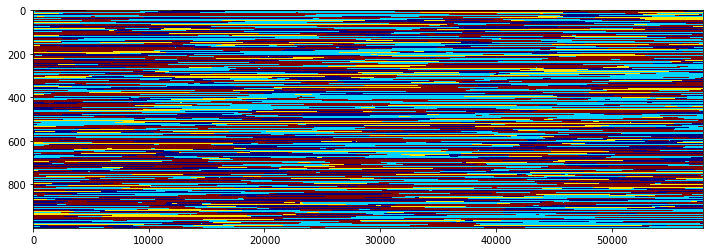

In [49]:
plt.figure(figsize=(12,4))
plt.imshow(train_Y[-1000:,:].astype(int), aspect='auto', cmap='jet')

## Build model

In [50]:
def custom_u(input_shape):
    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(shape=input_shape)

    # First convolutional block
    #conv0 = Conv1D(filters=input_shape[1], kernel_size=1, padding='same')(X_input)
    #drop1 = Dropout(0.33)(conv0)
    ks=8
    conv1 = Conv1D(filters=64, kernel_size=ks, padding = 'same')(X_input)
    bn1 = BatchNormalization(axis = -1)(conv1)
    conv1 = Activation('relu')(bn1)
    pool1 = MaxPooling1D(2)(conv1)

    # Second convolutional block with maxpool
    conv2 = Conv1D(filters=128, kernel_size=ks, padding = 'same', name = 'conv1')(bn1)
    bn2 = BatchNormalization(axis = -1)(conv2)
    conv2 = Activation('relu')(bn2)
    pool2 = MaxPooling1D(2)(conv2)

    # Third convolutional block with maxpool
    conv3 = Conv1D(filters=512, kernel_size=ks, padding = 'same')(pool2)
    bn3 = BatchNormalization(axis = -1)(conv3)
    conv3 = Activation('relu')(bn3)    
    pool3 = MaxPooling1D(2)(conv3)
        
    # Now you just go back up
    conv4 = Conv1D(filters=512, kernel_size=ks, padding='same')(pool3) # (UpSampling1D(size = 2)(pool3))
    conv4 = Activation('relu')(conv4)
    merge4= concatenate([conv4, pool3], axis=1)
    conv5 = Conv1D(filters=512, kernel_size=ks, padding='same')(merge4)
    conv5 = Activation('relu')(conv5)

    conv6 = Conv1D(filters=128, kernel_size=ks, padding = 'same')(conv5) # (UpSampling1D(size = 2)(conv5))
    bn6 = BatchNormalization(axis = -1)(conv6)
    conv6 = Activation('relu')(bn6)
    merge6= concatenate([conv6, pool2], axis=1)
    conv7 = Conv1D(filters=64, kernel_size=ks, padding = 'same')(merge6)
    conv7 = Activation('relu')(conv7)
    Yhat = Conv1D(k, kernel_size=1, activation = 'softmax')(conv7)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = Yhat, name='model2b')
    
    return model

In [51]:
def unet(input_shape, ks=4):
    # ref: https://github.com/zhixuhao/unet
    X_input = Input(shape=input_shape)

    fsh=1 # fudge factor to reduce size
    conv1 = Conv1D(filters=64, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(X_input)
    conv1 = Conv1D(filters=64, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=128//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv1D(filters=128//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    conv3 = Conv1D(filters=256//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv1D(filters=256//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)
    conv4 = Conv1D(filters=512//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv1D(filters=512//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling1D(pool_size=2)(conv4)
        
    conv5 = Conv1D(filters=1024//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv1D(filters=1024//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv5)

    up6 = Conv1D(filters=512//fsh, kernel_size=ks//2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv5))
    merge6 = concatenate([conv4,up6], axis = -1)
    conv6 = Conv1D(filters=512//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv1D(filters=512//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv6)

    up7 = Conv1D(filters=256//fsh, kernel_size=ks//2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv6))
    merge7 = concatenate([conv3,up7], axis = -1)
    conv7 = Conv1D(filters=256//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv1D(filters=256//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv7)

    up8 = Conv1D(filters=128//fsh, kernel_size=ks//2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = -1)
    conv8 = Conv1D(filters=128//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv1D(filters=128//fsh, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv8)

    up9 = Conv1D(filters=64, kernel_size=ks//2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv8))
    merge9 = concatenate([conv1,up9], axis = -1)
    conv9 = Conv1D(filters=64, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv1D(filters=64, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv1D(filters=2*k, kernel_size=ks, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv1D(filters=k, kernel_size=1, activation = 'softmax')(conv9)
    
    model = Model(inputs = X_input, outputs = conv10, name='model3')
    
    return model


In [52]:
def cnn(input_shape):
    # ref: https://github.com/zhixuhao/unet
    X_input = Input(shape=input_shape)
    
    # hopefully a big feature extractor
    conv1={}
    max_pow=10
    for f in [2**i for i in range(max_pow)]:
        if False: #f==2**(max_pow-1):
            conv1[f] = Conv1D(filters=3, kernel_size=f, activation='relu', padding='same',
                              kernel_initializer = 'he_normal')(X_input)            
        elif False: #f==1:
            conv1[f] = Conv1D(filters=1, kernel_size=1, activation='relu', padding='same',
                              kernel_initializer = 'he_normal')(X_input) 
        else:
            conv1[f] = Conv1D(filters=2*f if False else 64, kernel_size=f, activation='relu', padding='same',
                              kernel_initializer = 'he_normal')(X_input)
    conv1 = concatenate(list(conv1.values()), axis=-1)
    bn1 = BatchNormalization(axis = -1)(conv1)
    bn1 = Activation('relu')(bn1)
    
    # do something with those features
    dens2 = Dense(64, activation='tanh')(bn1)
    conv2 = Conv1D(filters=32, kernel_size=64, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(dens2)
    # pool2 = MaxPooling1D(pool_size=4)(conv2)
    
    # output layer, sure why not, idk
    #conv3 = Conv1D(filters=k, kernel_size=1, activation='softmax', padding='same', 
    #               kernel_initializer = 'he_normal')(conv2)
    conv3 = Dense(k, activation='softmax')(conv2)

    return Model(inputs=X_input, outputs=conv3, name='yolo')
    
    

## Create and compile the model 

In [53]:
# create model
nc,nv= 512, 4096 # train_X.shape[:2]
keep=np.random.choice(np.arange(train_X.shape[0]), replace=False, size=nc)
# keep=np.random.choice(np.arange(4608), replace=False, size=nc)
model = cnn(train_X[keep,:nv].shape[1:])
# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])
# summarize model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4096, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4096, 64)     320         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 4096, 64)     576         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 4096, 64)     1088        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (

## Train model

In [54]:
history=model.fit(train_X[keep,:nv,:], np.expand_dims(train_Y[keep,:nv], 2), epochs = 2, batch_size = 32)

Epoch 1/2
512/512 [==============================] - 62s 121ms/step - loss: 1.4420 - sparse_categorical_accuracy: 0.2799
Epoch 2/2
512/512 [==============================] - 61s 118ms/step - loss: 1.3916 - sparse_categorical_accuracy: 0.2999


## Evaluate model

Text(0.5, 1.0, 'Loss')

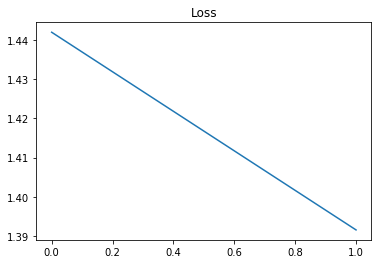

In [55]:
plt.plot(history.history['loss'], label='train')
plt.title('Loss')

In [56]:
# model.save('cnn_lai_v01_20200306.h5')

In [57]:
dev_Y_hat = model.predict(dev_X[:,:nv,:])

In [63]:
print('Confusion Matrix')
print(multilabel_confusion_matrix(dev_Y[:,:nv].astype(int).flatten(), 
                                  np.argmax(dev_Y_hat, axis=-1).flatten()))

Confusion Matrix
[[[414586  60550]
  [107420  15460]]

 [[241353 225591]
  [ 67270  63802]]

 [[480449   2879]
  [113979    709]]

 [[227380 141260]
  [141611  87765]]]


In [66]:
print('\n# Evaluate on dev set')
results = model.evaluate(dev_X[:,:nv,:], np.expand_dims(dev_Y[:,:nv], 2), batch_size=1)
print('dev set loss, acc:', results)


# Evaluate on dev set
146/146 [==============================] - 6s 43ms/step
dev set loss, acc: [1.4284940794722674, 0.2804874785958904]


In [69]:
# take number of ancestors as Pois(2.86 * generation_time), over 1-10 (maxgen) generations
n_fake=1000
maxgen=10
n_splits=2+np.hstack([ss.poisson.rvs(2.86*gen, size=n_fake//maxgen) for gen in range(1,maxgen)])

# new individuals
new_X=[]
new_Y=[]
for j in n_splits:
    if j==0:
        ind=np.random.choice(np.arange(dev_X.shape[0]), size=1)
        new_X.append(list(dev_X[ind,:,:]))
        new_Y.append(list(dev_Y[ind,:]))
    # sample breakpoints uniformly
    breaks=np.sort(V.shape[0] * ss.beta.rvs(a=1, b=1, size=j)).astype(int)
    # pick founders uniformly at random without replacement and stitch their labels together
    founds=np.random.choice(np.arange(dev_X.shape[0]), size=j+1, replace=False)
    # assemble genome and labels
    new_x,new_y = [],[]
    new_x.append(dev_X[founds[0],:breaks[0],:])
    new_y.append(dev_Y[founds[0],:breaks[0]])
    for i,found in enumerate(founds[1:-1]):
        new_x.append(dev_X[found, breaks[i]:breaks[i+1],:])
        new_y.append(dev_Y[found, breaks[i]:breaks[i+1]])
    new_x.append(dev_X[founds[-1], breaks[-1]:,:])
    new_y.append(dev_Y[founds[-1], breaks[-1]:])
    new_X.append(np.vstack(new_x))
    new_Y.append(np.hstack(new_y))
devv_X=np.vstack((dev_X, new_X))
devv_Y=np.vstack((dev_Y, new_Y))
[devv_X.shape, devv_Y.shape]

[(1046, 57876, 4), (1046, 57876)]

In [70]:
print('\n# Evaluate on dev set')
results = model.evaluate(devv_X[:,:nv,:], np.expand_dims(devv_Y[:,:nv], 2), batch_size=1)
print('dev set loss, acc:', results)


# Evaluate on dev set
1046/1046 [==============================] - 42s 40ms/step
dev set loss, acc: [1.4356237591794527, 0.2764523799743069]
